In [0]:
  %tensorflow_version 2.x
import tensorflow as tf

TensorFlow 2.x selected.


In [0]:
# text preprocessing
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [0]:
# model and layers
# model
from tensorflow.keras.models import Model
# layers
from tensorflow.keras.layers import Dense, Input, GlobalMaxPooling1D
from tensorflow.keras.layers import LSTM, Embedding

In [0]:
# Additional imports
import numpy as np # linear algebra
import pandas as pd # data manipulation
import matplotlib.pyplot as plt # data visusalisation

from sklearn.model_selection import train_test_split # to split the data into train and test sets

In [0]:
# download the dataset
!wget https://lazyprogrammer.me/course_files/spam.csv

--2020-03-17 11:01:02--  https://lazyprogrammer.me/course_files/spam.csv
Resolving lazyprogrammer.me (lazyprogrammer.me)... 104.31.81.48, 104.31.80.48, 2606:4700:3035::681f:5130, ...
Connecting to lazyprogrammer.me (lazyprogrammer.me)|104.31.81.48|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 503663 (492K) [text/csv]
Saving to: ‘spam.csv’

spam.csv            100%[===================>] 491.86K  --.-KB/s    in 0.02s   

2020-03-17 11:01:03 (23.9 MB/s) - ‘spam.csv’ saved [503663/503663]



In [0]:
!head spam.csv

UnicodeDecodeError: ignored

In [0]:
# Well, I guess we gotta load the data using different encoding
# It appears correct encoding is ISO-8859-1
# source: https://stackoverflow.com/questions/19699367/for-line-in-results-in-unicodedecodeerror-utf-8-codec-cant-decode-byte
df = pd.read_csv('spam.csv', encoding = 'ISO-8859-1')

In [0]:
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [0]:
# We should drop these "Unnamed" columns which are not useful for our 
# project
df = df.drop(['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'], axis = 1)
df.head()

,v1,v2
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [0]:
# So now v1 is the labels and the v2 is the emails.
# We can rename the columns something better than v1,v2
df.columns = ['labels', 'data'] # thats better
df.head() 

,labels,data
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [0]:
# well, the labels are strings. We can create binary labels
# since thats what we'd be using
# Both of the approaches are correct.
# df['b_labels'] = df['labels'].map({'ham':0, 'spam':1}) 
df['b_labels'] = df['labels'].map(lambda x: 1 if x == "spam" else 0)
Y = df['b_labels'].values
df.head()

,labels,data,b_labels
0,ham,"Go until jurong point, crazy.. Available only ...",0
1,ham,Ok lar... Joking wif u oni...,0
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,1
3,ham,U dun say so early hor... U c already then say...,0
4,ham,"Nah I don't think he goes to usf, he lives aro...",0


In [0]:
# Split up the data
df_train, df_test, y_train, y_test = train_test_split(df['data'], Y, test_size = .33)

In [0]:
# Convert sentences to sequences
MAX_VOCAB_SIZE = 20000
tokenizer = Tokenizer(num_words = MAX_VOCAB_SIZE)
tokenizer.fit_on_texts(df_train)
sequences_train = tokenizer.texts_to_sequences(df_train)
sequences_test = tokenizer.texts_to_sequences(df_test)

In [0]:
# get word -> integer mapping
word2idx = tokenizer.word_index
V = len(word2idx)
print('Found {} unique tokens.'.format(V))

Found 7272 unique tokens.


In [0]:
# add the padding to the sequences so that we get a NxT matrix
data_train = pad_sequences(sequences_train)
print('Shape of data train tensor:', data_train.shape)

# get sequence length
T = data_train.shape[1]

Shape of data train tensor: (3733, 189)


In [0]:
data_test = pad_sequences(sequences_test, maxlen = T)
print('Shape of data test tensor:', data_test.shape)

Shape of data test tensor: (1839, 189)


In [0]:
# Create the model

# We get to choose embedding dimensionality
D = 20 # hyperparameter
# Hidden state dimensionality
M = 15 # hyperparameter

# NOTE: We actually want to the size of the embedding to (V + 1) x D,
# because the first index starts from 1 and not 0
# Thus, if the final index of the embedding matrix is V,
# then it actually must've size V + 1,

i = Input(shape = (T,))
x = Embedding(V + 1, D)(i)
x = LSTM(M, return_sequences=True)(x)
x = GlobalMaxPooling1D()(x)
x = Dense(1, activation = 'sigmoid')(x)

model = Model(i,x)

# Compile and fit
model.compile(
    loss = 'binary_crossentropy',
    optimizer = 'adam',
    metrics = ['accuracy']
)

print('Training model...')
r = model.fit(
    data_train,
    y_train,
    epochs = 10,
    validation_data = (data_test, y_test)
)

In [0]:
# Compile and fit
model.compile(
    loss = 'binary_crossentropy',
    optimizer = 'adam',
    metrics = ['accuracy']
)

print('Training model...')
r = model.fit(
    data_train,
    y_train,
    epochs = 10,
    validation_data = (data_test, y_test)
)

Training model...
Train on 3733 samples, validate on 1839 samples
Epoch 1/10
3733/3733 [==============================] - 12s 3ms/sample - loss: 0.4588 - accuracy: 0.8620 - val_loss: 0.3747 - val_accuracy: 0.8738
Epoch 2/10
3733/3733 [==============================] - 5s 1ms/sample - loss: 0.3688 - accuracy: 0.8620 - val_loss: 0.3208 - val_accuracy: 0.8738
Epoch 3/10
3733/3733 [==============================] - 5s 1ms/sample - loss: 0.2993 - accuracy: 0.8620 - val_loss: 0.2408 - val_accuracy: 0.8738
Epoch 4/10
3733/3733 [==============================] - 4s 1ms/sample - loss: 0.2017 - accuracy: 0.8878 - val_loss: 0.1698 - val_accuracy: 0.9668
Epoch 5/10
3733/3733 [==============================] - 5s 1ms/sample - loss: 0.1292 - accuracy: 0.9826 - val_loss: 0.1328 - val_accuracy: 0.9799
Epoch 6/10
3733/3733 [==============================] - 4s 1ms/sample - loss: 0.0889 - accuracy: 0.9896 - val_loss: 0.1127 - val_accuracy: 0.9777
Epoch 7/10
3733/3733 [==============================] - 4

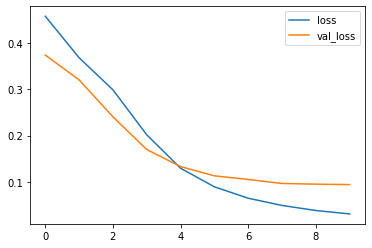

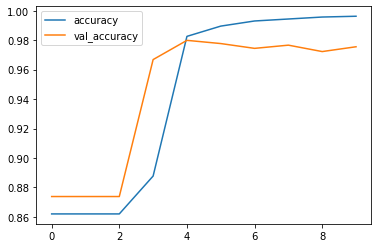

In [0]:
# Plot the loss and accuracy per iteration
# loss
plt.plot(r.history['loss'], label = 'loss')
plt.plot(r.history['val_loss'], label = 'val_loss')
plt.legend()
plt.show()

# accuracy
plt.plot(r.history['accuracy'], label = 'accuracy')
plt.plot(r.history['val_accuracy'], label = 'val_accuracy')
plt.legend()
plt.show()